In [1]:
import os
import time
import numpy as np
import cv2
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import joblib


from IPython.display import clear_output
from scipy.ndimage.filters import gaussian_filter1d   ## smoother

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data.dataset import random_split


from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torchvision.transforms import ToPILImage
from albumentations import *
from sklearn.preprocessing import MinMaxScaler

plt.rcParams['image.cmap'] = 'gray'

In [ ]:
!pip install --upgrade scikit-learn

## Estimating the population of various lineages of cells within the C. elegans embryo using deep learning. 

For this use case we'll be using the ResNet architeture with a custom last layer to fit the labels 

### But before that, we'll have to load up the data. 


In [ ]:
!cp /content/drive/"My Drive"/data/clean_training_data.csv /content/
!cp /content/drive/"My Drive"/zip/frames_raw.zip /content/
!unzip frames_raw.zip 

## Filter for debugging

* `clean_training_data.csv` contains all the filename of the images along with the populations values of each cell lineage for the given photo.
* `a_pop_lower_limit` can be used to remove the images which had a very low number of cells within the embryo, this was initially required because the images with very low cell populations were either very noisy or corrupt. Set it to 0 to load up all the images.
* `look_for_tag` can be used to load up a single embryo instace or or a certain strain of cells like ceh-32, but here we use it to look for image files with the tag "L1" to load up images only upto the L1 stage in the embryo. To know about the various stages of embryogenesis of the C. elegans, have a look at [wormbook](http://www.wormbook.org/)

In [87]:
df = pd.read_csv("clean_training_data.csv")
a_pop_upper_limit = 250

look_for_tag = "ceh-"
avoid_tags = ["20080819_ceh-41_14_L1", 
              "20081108_ceh-36_b13_L1"]

df = df[df["A"] <= a_pop_upper_limit]
df = df[df["filenames"].str.contains(look_for_tag) == True]

for tag in avoid_tags:
    df = df[df["filenames"].str.contains(tag) == False]


print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3547 entries, 526 to 51699
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  3547 non-null   int64 
 1   filenames   3547 non-null   object
 2   A           3547 non-null   int64 
 3   E           3547 non-null   int64 
 4   M           3547 non-null   int64 
 5   P           3547 non-null   int64 
 6   C           3547 non-null   int64 
 7   D           3547 non-null   int64 
 8   Z           3547 non-null   int64 
dtypes: int64(8), object(1)
memory usage: 277.1+ KB
None


## Scaling the training data

Initially, the training was done on non scaled data, and the values of all the populations except the "A" lineage were ranging from 0 to 20 or so. While A ranged from 0 to as high as 350. So the model, even after training was able to predict the population of "A" very well, but not the others, because they didn't contribute to the loss as much as "A" did. 

This was fixed by normalising all the columns within `[-1. ,1.]`, so that all of them contribute equally to the loss in th 7D vector space. 

We had to use the `sklearn.preprocessing.MinMaxScaler` to scale all the columns in the dataframe. The scaled training data gets saved as [scaled_training_data.csv](https://github.com/devoworm/GSoC-2020/blob/master/Pre-trained%20Models%20(DevLearning)/notebooks/embryo_analysis/video_analysis/data/scaled_training_data.csv). 

*Note: If you want the frames associated with the metadata given above, do contact any one of the [contributors](https://github.com/devoworm/GSoC-2020/graphs/contributors) from the Devoworm GSoC 2020 repo*

In [88]:
data =  df[["A", "E", "M", "P", "C", "D", "Z"]].values
scaler = MinMaxScaler()
print("Scaler = ", scaler.fit(data))
print("Minimun values of each column = ", scaler.data_min_)
print("Maximum values of each column = ", scaler.data_max_)

joblib.dump(scaler, 'scaler.gz')

Scaler =  MinMaxScaler()
Minimun values of each column =  [0. 0. 0. 0. 0. 0. 0.]
Maximum values of each column =  [250.  14.  43.   1.  26.   8.   2.]


['scaler.gz']

In [89]:
new_data = scaler.transform(data)
print(new_data.shape)
new_df = pd.DataFrame(new_data)
new_df["filenames"] = df["filenames"].values
new_df.columns = ["A", "E", "M", "P", "C", "D", "Z", "filenames"]
final_df = new_df 

final_df.to_csv("scaled_training_data.csv", index = False)
final_df.tail(5)

(3547, 7)


,A,E,M,P,C,D,Z,filenames
3542,0.936,0.857143,0.883721,1.0,0.807692,1.0,1.0,frames/20081013_ceh-16_b7_L1/205.jpg
3543,0.960,0.857143,0.906977,1.0,0.807692,1.0,1.0,frames/20081013_ceh-16_b7_L1/206.jpg
3544,0.980,1.000000,0.906977,1.0,0.846154,1.0,1.0,frames/20081013_ceh-16_b7_L1/207.jpg
3545,0.980,1.000000,0.906977,1.0,0.846154,1.0,1.0,frames/20081013_ceh-16_b7_L1/208.jpg
3546,1.000,1.000000,0.906977,1.0,0.846154,1.0,1.0,frames/20081013_ceh-16_b7_L1/209.jpg


## Buiding a custom class to load up the images with the metadata. 
* `labels_csv_path` is the paths of the scaled dataframe that we saved in the cells above
* `augmentation` supports image augmentation functions from the [albuentations](https://github.com/albumentations-team/albumentations) library.  
* Set `RGB = True` when training a model with 3 color channels (like the pretrained ResNet), and `false` for single channel (grayscale) images. 
* `preprocess_image` is an optional function which can be used to preprocess the images before the forward pass. 

In [90]:
class ImageDataset(Dataset):   
    def __init__(self, labels_csv_path, preprocess_image= False, augmentation =None, transform = None, RGB = False):
        
        self.df = pd.read_csv(labels_csv_path)
        self.image_paths = self.df.filenames.values
        self.labels = self.df[["A", "E", "M", "P", "C", "D", "Z"]].values
        self.transform = transform
        self.augmentation = augmentation
        self.preprocess = preprocess_image
        self.RGB = RGB

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        
        if self.RGB == False:
            image = cv2.imread(path, 0)
        else:
            image = cv2.imread(path)

        if self.preprocess == True:
            image = preprocess_image_np(image)

        if self.augmentation is not None:
            img  = self.augmentation(image = image)
            image = img["image"]
            
        label = torch.Tensor(self.labels[idx]).float()

        return self.transform(image) , label 

    def __len__(self):
        return len(self.image_paths)

In [91]:
full_dataset = ImageDataset(labels_csv_path = "scaled_training_data.csv",
                         augmentation = Compose([ 
                                                VerticalFlip(p=0.5),
                                                HorizontalFlip(p=0.5),
                                                RandomContrast(limit=0.9, p=0.5),
                                                Transpose(p=0.5),
                                                 ElasticTransform(p=0.5, alpha=30, sigma=120 * 0.05, alpha_affine=120 * 0.03)

                                            ]),
                        transform = transforms.Compose([    
                                                        transforms.ToPILImage(),
                                                        transforms.Resize((256,256), interpolation = Image.NEAREST),
                                                        torchvision.transforms.RandomAffine(degrees = 10, translate= (0.1, 0.1), scale=None, shear=None, resample=False, fillcolor=0),
                                                        ToTensor(),
                                                        transforms.Normalize(0.5, 0.5, 0.5)
                                                        ]),
                        RGB = True ## set to true for ResNet
                            )

## Train - test split



In [92]:
train_size = int(0.9* len(full_dataset))  ## 90/10 split
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=63, shuffle=True)

val_loader = DataLoader(dataset=test_dataset, batch_size= 7, shuffle = True)

print(len(train_loader), "batches ")
print(len(val_loader), " batches ")

51 batches 
51  batches 


## Utils for output visualization


In [93]:
def inverse_transform_prediction(output):
    lab = output.numpy().reshape(1,-1) ## convert to 2d np array
    lab = scaler.inverse_transform(lab).flatten() ## back to original domain
    lab = [int(i) for i in lab] ## convert to int 
    return lab

def show_preds(model, batch):
    fig, ax = plt.subplots(3,3, figsize = (15,15))
    images , labels = batch
    model.eval()
    preds = model(images.cuda()).cpu().detach()
    for i in range (9):
        ax.flat[i].imshow(images[i][0])
        text = "label = "+ str(inverse_transform_prediction(labels[i]))  + "  pred = " + str(inverse_transform_prediction(preds[i]))
        ax.flat[i].set_xlabel(text , fontsize= 10)

def show_batch(batch):
    fig, ax = plt.subplots(4,4, figsize = (19,19))
    images , labels = batch
    for i in range (16):
        ax.flat[i].imshow(images[i][0])
        lab = inverse_transform_prediction(labels[i])
        ax.flat[i].set_xlabel("label = "+ str(lab), fontsize= 15)

## Visualizing a batch

The labels shows here have went through the `scaler.inverse_transform()` to show the original populations instead of the scaled float values. 

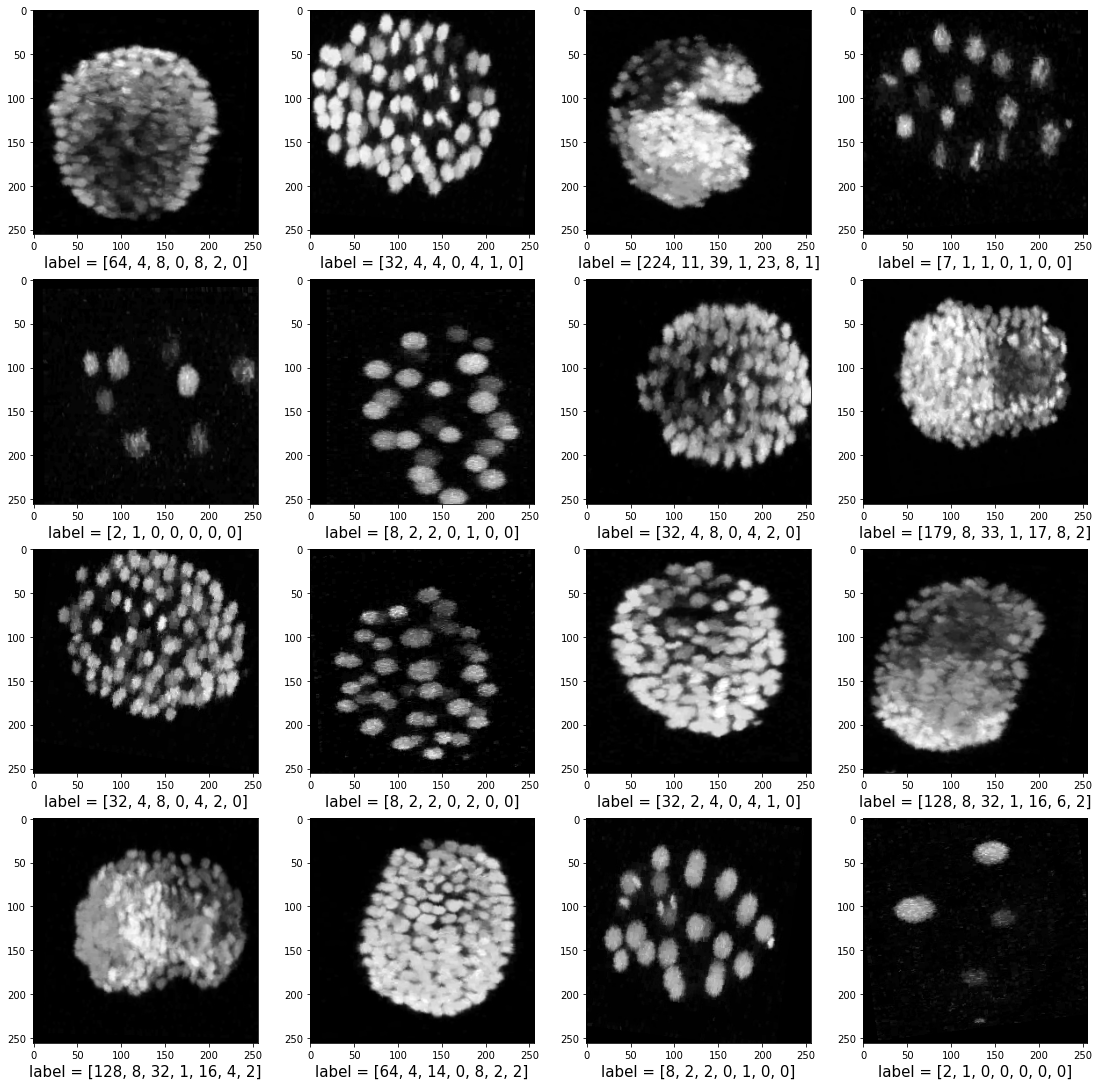

In [94]:
batch = next(iter(train_loader))
show_batch(batch)

In [95]:
def vis_loss_multi(loss_arr,val_arr):
    ysmoothed = gaussian_filter1d(loss_arr, sigma=7)
    plt.plot( ysmoothed, label = "training loss")
    ysmoothed2 = gaussian_filter1d(val_arr, sigma=18)
    plt.plot(ysmoothed2, label = "validation loss")
    plt.show()

def vis_loss_multi_colors(loss_arr,val_arr):
    ysmoothed = gaussian_filter1d(loss_arr, sigma=3)
    plt.plot( ysmoothed, "c", label = "training")
    ysmoothed2 = gaussian_filter1d(val_arr, sigma=7)
    plt.plot(ysmoothed2, "g", label = "validation")
    plt.grid(True)
    plt.ylabel("Loss", fontsize = 15)                                       
    plt.xlabel("batches", fontsize=15)
    plt.legend()
    plt.show()     

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
        
def show_lr(learning_rates):
    plt.plot(learning_rates, label = "learning rate")
    plt.ylabel("Learning rate", fontsize = 15)
    plt.grid(True)
    plt.legend()
    plt.show()

def show_deltas(deltas):
    deltas = gaussian_filter1d(deltas, sigma=3)
    plt.plot(deltas, "r", label = "Absolute error from label ")
    plt.ylabel("Error", fontsize = 15)
    plt.grid(True)
    plt.legend()
    plt.show()

## The training loop

The `train_model()` function has been conveniently written so that anyone can customize it easily for experimentation through the `config` dictionary, more on that later. 


In [96]:
def train_step(x, y, model, optimizer, criterion):
        optimizer.zero_grad()
        pred = model(x)
        y = y.float()
        loss = criterion(pred,y)
        loss.backward()
        optimizer.step()
        return loss.item()


def train_model(config):

    epochs = config["epochs"]
    model = config["model"]
    train_loder = config["train_loader"]
    val_loader = config["val_loader"]
    optimizer = config["optimizer"]
    scheduler = config["scheduler"]
    criterion = config["loss_function"]

    start = time.process_time()
    losses = []
    val_losses = []
    learning_rates = []
    average_deltas = []

    for m in range (epochs):
        clear_output(wait = True)
        vis_loss_multi_colors(losses, val_losses)
        show_lr(learning_rates)
        show_deltas(average_deltas)
        print ("epoch ", m+1, " out of ", epochs )
        
        ## run on validation loader
        with torch.no_grad():
            model.eval()

            for x_val, y_val in tqdm(val_loader, desc = "running on test set --"):
                yhat =model(x_val.cuda())  # pred 
                val_loss = criterion(yhat.cuda(), y_val.cuda())
                val_losses.append(val_loss.item())  ## metrics 
                average_deltas.append(torch.mean(torch.abs(yhat.cpu()-y_val.cpu())).item())

        ## run on train loader 
        model.train()
        for batch in tqdm(train_loader, desc = " Training batches : "):

                (x_batch, y_batch) = batch
                loss = train_step(x_batch.cuda(), y_batch.cuda(), model, optimizer, criterion)
                losses.append(loss)
                
        scheduler.step(1.)   ## lr decay caller 
        learning_rates.append(get_lr(optimizer))
        

    clear_output(wait = True)

    vis_loss_multi_colors(losses, val_losses)
    show_lr(learning_rates)
    show_deltas(average_deltas)

    print ("Time elapsed = ", time.process_time() - start, " seconds" )
    return losses

## Loading up the pre-trained ResNet18 for training
* The only modification we made was to set `model.fc = nn.Linear(512, 7)` to change the output layer's size to 7 

In [97]:
import torchvision.models as models

model = models.resnet18(pretrained = True)
model.fc = nn.Linear(512, 7)  ## resize last layer 

model = model.cuda()

optimizer = optim.Adam(model.parameters(), lr = 0.001) 

scheduler = ReduceLROnPlateau(optimizer, 
                                mode='min', 
                                factor=0.5, 
                                patience=2, 
                                verbose=False, 
                                threshold=0.0001, 
                                threshold_mode='rel', 
                                cooldown=0, 
                                min_lr=0, 
                                eps=1e-08)

## The training config
* `epochs` determines the number of epochs that the model has to train through. 
* `model` specifies the `nn.Module` subclass (neural network) to be trained  
* `train_loader` and `val_loader` are the `DataLoader` instances for training and validation sets 
* `scheduler` specifies the special funcions which are scheduled once per epoch to adjust the learning rate. 
* `loss_function` is the loss function that is to be used for backpropagation 

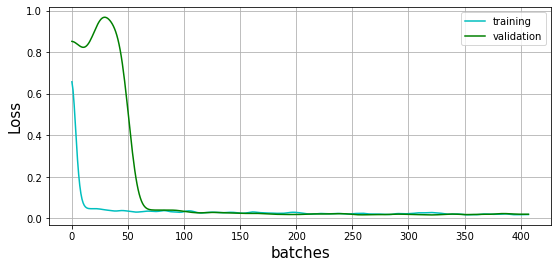

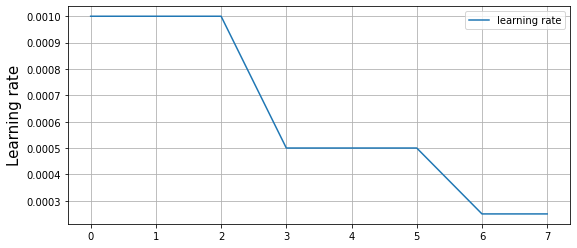

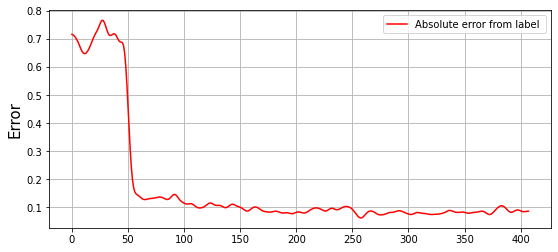

Time elapsed =  494.8613101179999  seconds


In [98]:
plt.rcParams["figure.figsize"] = (9,4)

config = { 
        "epochs" : 8,    
        "model" : model,      
        "train_loader" : train_loader, 
        "val_loader" : val_loader,
        "optimizer" : optimizer,
        "scheduler" : scheduler,
        "loss_function" : nn.MSELoss()
        }

losses = train_model(config)

### Saving the model

In [99]:
save_path = "/content/drive/My Drive/models/pre_clean_l1_estimate_lineage_population_resnet18.pt"
torch.save(model.state_dict(), save_path)

## Removing lossy frames 

Unitl now, the model was trained on partially cleaned data. But now we can use the model itself to clean up the rest, by removing the frames which gave the most loss after a forward pass. These frames are mostly mis-labeled black/dark grey frames near the ends of videos. 

In [100]:
df_test = pd.read_csv("scaled_training_data.csv")

labels = df_test[['A', 'E', 'M', 'P', 'C', 'D', 'Z']].values
filenames = df_test.filenames.values


In [101]:
mini_transform = transforms.Compose([
                                     transforms.ToPILImage(),
                                     transforms.Resize((256,256), interpolation = Image.NEAREST),
                                     transforms.ToTensor(),
                                     transforms.Normalize(0.5, 0.5, 0.5)
])

## Calculating the loss on each image in the complete dataset 

In [ ]:
def path_to_result(path, model):
    model.eval()
    im = cv2.imread(path)
    tensor = mini_transform(im).unsqueeze(0).cuda()
    res = model(tensor).detach().cpu().numpy().flatten()
    return res


def calc_abs_loss(pred,label):
    loss = np.sum(np.abs(pred-label))
    return loss

losses = []
preds = []

for i in tqdm(range(len(filenames))):
    pred = path_to_result(filenames[i], model )
    preds.append(pred)
    loss = calc_abs_loss(pred, labels[i])
    losses.append(loss)

losses = np.array(losses)

## Dropping the top 1% images with the most loss

Because it is pretty likey that these are either corrupt frames or just plain black frames with the noise occurring randomly at the end of the videos

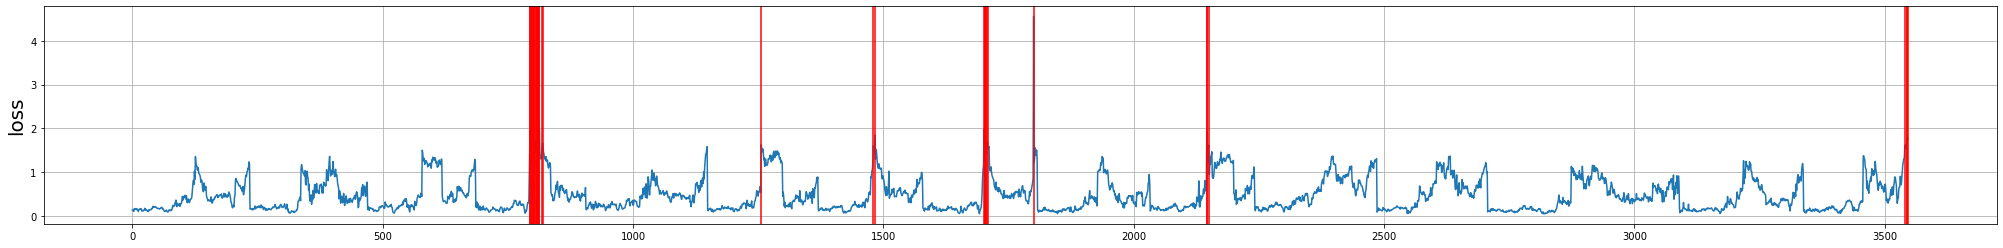

In [103]:
percentage = 1
num_bad = int((len(filenames)/100) * percentage)
indices_of_bad_pictures = (-losses).argsort()[:num_bad]

plt.rcParams["figure.figsize"] = (35,4)

plt.plot(losses)
plt.ylabel("loss", fontsize = 20)

for index in indices_of_bad_pictures:
    plt.axvline(x = index, c = "r")
plt.grid()
plt.show()

In [107]:
df_clean = df_test
df_clean = df_clean.drop(df_clean.index[indices_of_bad_pictures])
df_clean.to_csv("new_clean_training_data.csv")
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3512 entries, 0 to 3543
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   A          3512 non-null   float64
 1   E          3512 non-null   float64
 2   M          3512 non-null   float64
 3   P          3512 non-null   float64
 4   C          3512 non-null   float64
 5   D          3512 non-null   float64
 6   Z          3512 non-null   float64
 7   filenames  3512 non-null   object 
dtypes: float64(7), object(1)
memory usage: 246.9+ KB


## Re-train on clean images 

In [108]:
full_dataset = ImageDataset(labels_csv_path = "new_clean_training_data.csv",
                         augmentation = Compose([ 
                                                    VerticalFlip(p=0.5),
                                                    HorizontalFlip(p=0.5),
                                                    ]),
                            transform = transforms.Compose([    
                                                            transforms.ToPILImage(),
                                                            transforms.Resize((256,256), interpolation = Image.NEAREST),
                                                            torchvision.transforms.RandomAffine(degrees = 10, translate= (0.1, 0.1), scale=None, shear=None, resample=False, fillcolor=0),
                                                            ToTensor(),
                                                            transforms.Normalize(0.5, 0.5, 0.5)
                                                            ]),
                            RGB = True ## set to true for ResNet
                             )

train_size = int(0.9* len(full_dataset))  ## 90/10 split
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=18, shuffle=True)

val_loader = DataLoader(dataset=test_dataset, batch_size= 2, shuffle = True)

print(len(train_loader), "batches ")
print(len(val_loader), " batches ")


176 batches 
176  batches 


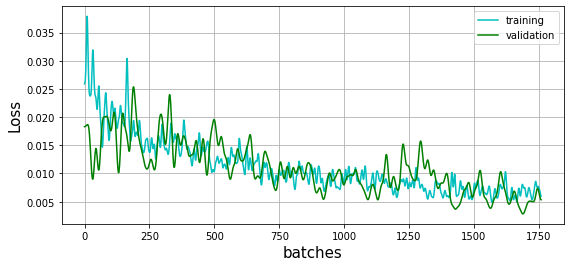

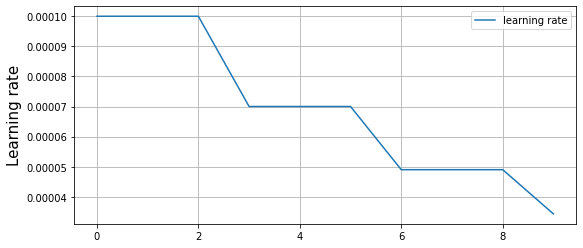

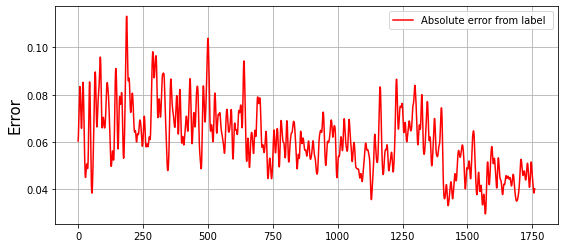

Time elapsed =  430.49484876299994  seconds


In [109]:
plt.rcParams["figure.figsize"] = (9,4)
optimizer = optim.Adam(model.parameters(), lr = 0.0001) 


scheduler = ReduceLROnPlateau(optimizer, 
                                mode='min', 
                                factor=0.7, 
                                patience=2, 
                                verbose=False, 
                                threshold=0.0001, 
                                threshold_mode='rel', 
                                cooldown=0, 
                                min_lr=0.0000001, 
                                eps=1e-08)


config = { 
        "epochs" : 10,    
        "model" : model,      
        "train_loader" : train_loader, 
        "val_loader" : val_loader,
        "optimizer" : optimizer,
        "scheduler" : scheduler,
        "loss_function" : nn.MSELoss()
        }

losses = train_model(config)

## Comparing the model's predictions with the real ones 

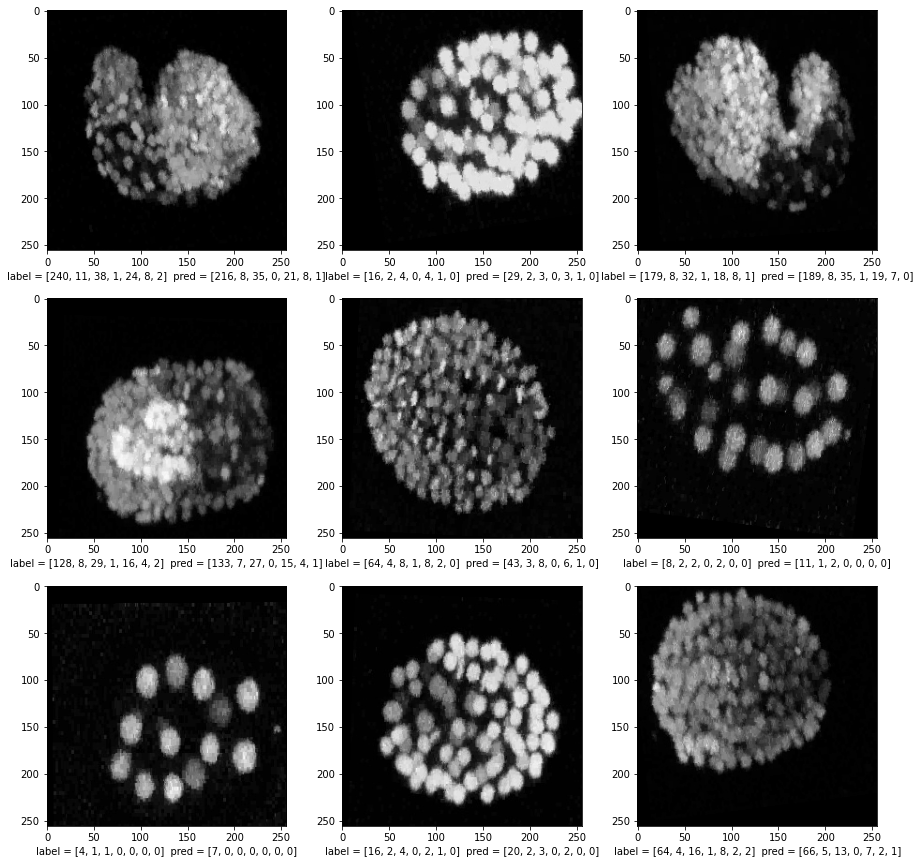

In [110]:
val_loader = DataLoader(dataset=test_dataset, batch_size= 16, shuffle = True)
batch = next(iter(val_loader))
show_preds(model , batch)

In [113]:
save_path = "/content/drive/My Drive/models/max_A_250_polished_estimate_lineage_population_resnet18.pt"
torch.save(model.state_dict(), save_path)

## Loading up the trained model further inferences 

In [114]:
model.load_state_dict(torch.load("/content/drive/My Drive/models/max_A_250_polished_estimate_lineage_population_resnet18.pt"))  

<All keys matched successfully>

## Plotting the predictions of a model on a single video 

* set `look_for_tag` to the video's filename without the extension to run the model on one particular video 

In [116]:
df_test = pd.read_csv("scaled_training_data.csv")
look_for_tag = "20071217_ceh-432x3"

a_pop_upper_limit = 250

df_test = df_test[df_test["A"] <= a_pop_upper_limit]

df_single_cell = df_test[df_test['filenames'].str.contains(look_for_tag)].head(360)
df_single_cell.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 360 entries, 2707 to 3066
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   A          360 non-null    float64
 1   E          360 non-null    float64
 2   M          360 non-null    float64
 3   P          360 non-null    float64
 4   C          360 non-null    float64
 5   D          360 non-null    float64
 6   Z          360 non-null    float64
 7   filenames  360 non-null    object 
dtypes: float64(7), object(1)
memory usage: 25.3+ KB


In [117]:
data = scaler.inverse_transform(df_single_cell[['A', 'E', 'M', 'P', 'C', 'D', 'Z']].values)

In [118]:
real_time_plots = []
for i in range(len(df_single_cell.columns[1:])):
    real_time_plots.append(data[:,i])

## Comparing real v/s "predicted" data
 We now showed the model all the frames from one single video and plotted it's population predictions. We then compared these predictions with the metadata of the video file. 

In [119]:
preds = []
filenames = df_single_cell.filenames.values
for i in range (len(filenames)):

    image = cv2.imread(filenames[i])
   
    tensor = mini_transform(image).unsqueeze(0).cuda()
    pred = model(tensor).cpu().detach().numpy().flatten()
    preds.append(pred)
    
preds = scaler.inverse_transform(np.array(preds)).astype(np.uint8)

In [120]:
generated_time_plots = []
for i in range(len(df_single_cell.columns[1:])):
    generated_time_plots.append(preds[:,i])

## It can be seen how the model's predictions "hover" around the real values
The model was not able to give accurate predictions on the earlier stages of the embryo for the "A" lineage probablu because of the random noise in the frames, this needs a fix. 

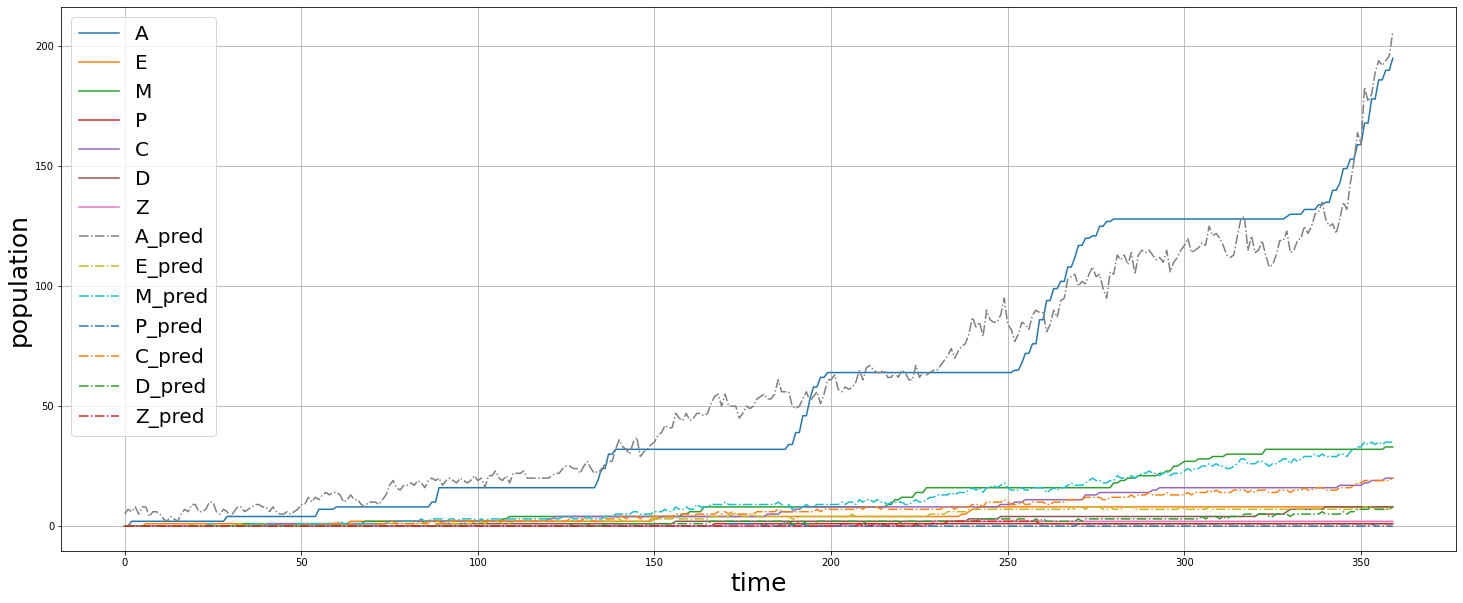

In [121]:
plt.rcParams['figure.figsize'] =25, 10

for i in range(len(real_time_plots)):
    plt.plot(real_time_plots[i], label = df_single_cell.columns[:-1][i] )


for i in range(len(generated_time_plots)):
    plt.plot(generated_time_plots[i], label = df_single_cell.columns[:-1][i] + "_pred", linestyle = "-." )

plt.xlabel("time", fontsize = 25)
plt.ylabel("population", fontsize = 25)
plt.legend(fontsize = 20)
plt.grid()


## Testing on more videos 

In [124]:
def researcher_vs_model(look_for_tag):

    df_test = pd.read_csv("scaled_training_data.csv")

    df_single_cell = df_test[df_test['filenames'].str.contains(look_for_tag)]

    a_pop_upper_limit = 250

    df_test = df_test[df_test["A"] <= a_pop_upper_limit]

    data = scaler.inverse_transform(df_single_cell[['A', 'E', 'M', 'P', 'C', 'D', 'Z']].values)
    real_time_plots = []
    for i in range(len(df_single_cell.columns[1:])):
        real_time_plots.append(data[:,i])


    preds = []
    filenames = df_single_cell.filenames.values
    for i in range (len(filenames)):

        image = cv2.imread(filenames[i])
    
        tensor = mini_transform(image).unsqueeze(0).cuda()
        pred = model(tensor).cpu().detach().numpy().flatten()
        preds.append(pred)
        
    preds = scaler.inverse_transform(np.array(preds)).astype(np.uint8)

    generated_time_plots = []
    for i in range(len(df_single_cell.columns[1:])):
        generated_time_plots.append(preds[:,i])

    plt.rcParams['figure.figsize'] =25, 10

    for i in range(len(real_time_plots)):
        plt.plot(real_time_plots[i], label = df_single_cell.columns[:-1][i] )


    for i in range(len(generated_time_plots)):
        plt.plot(generated_time_plots[i], label = df_single_cell.columns[:-1][i] + "_pred", linestyle = "--", linewidth = 2 )

    plt.xlabel("time", fontsize = 25)
    plt.ylabel("population", fontsize = 25)
    plt.legend(fontsize = 20)
    plt.grid()
    plt.show()

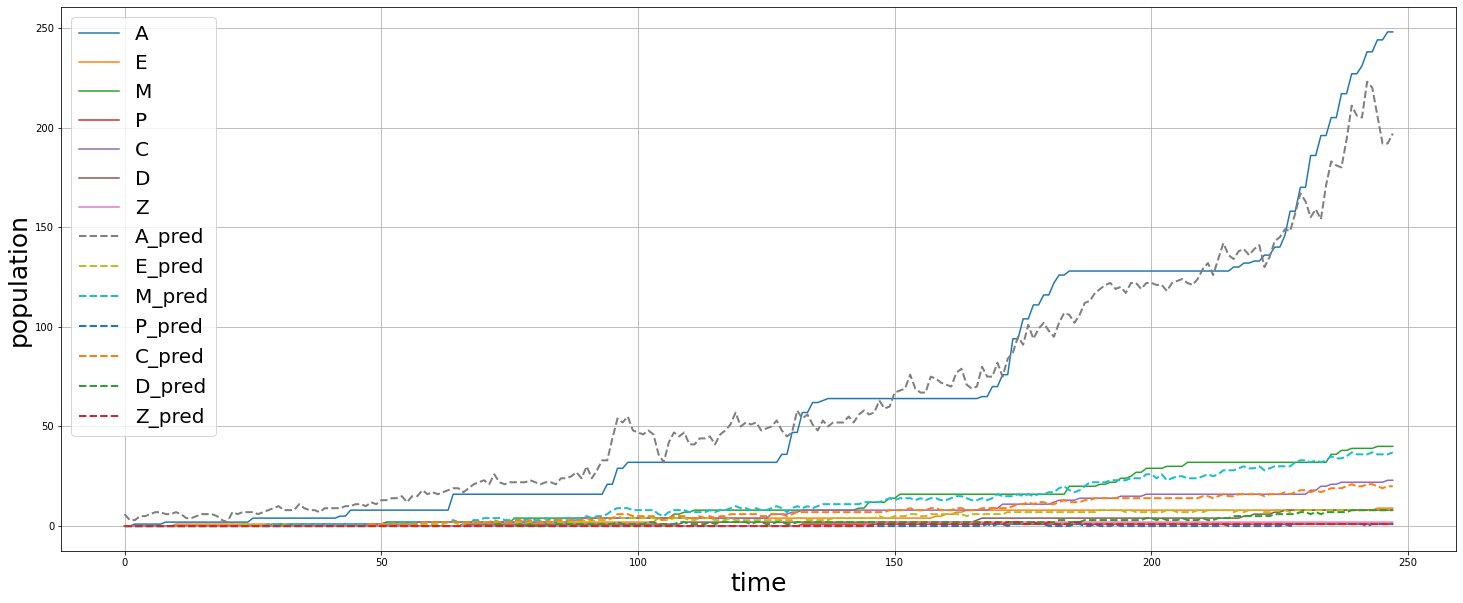

20080709_ceh-27_1_L1


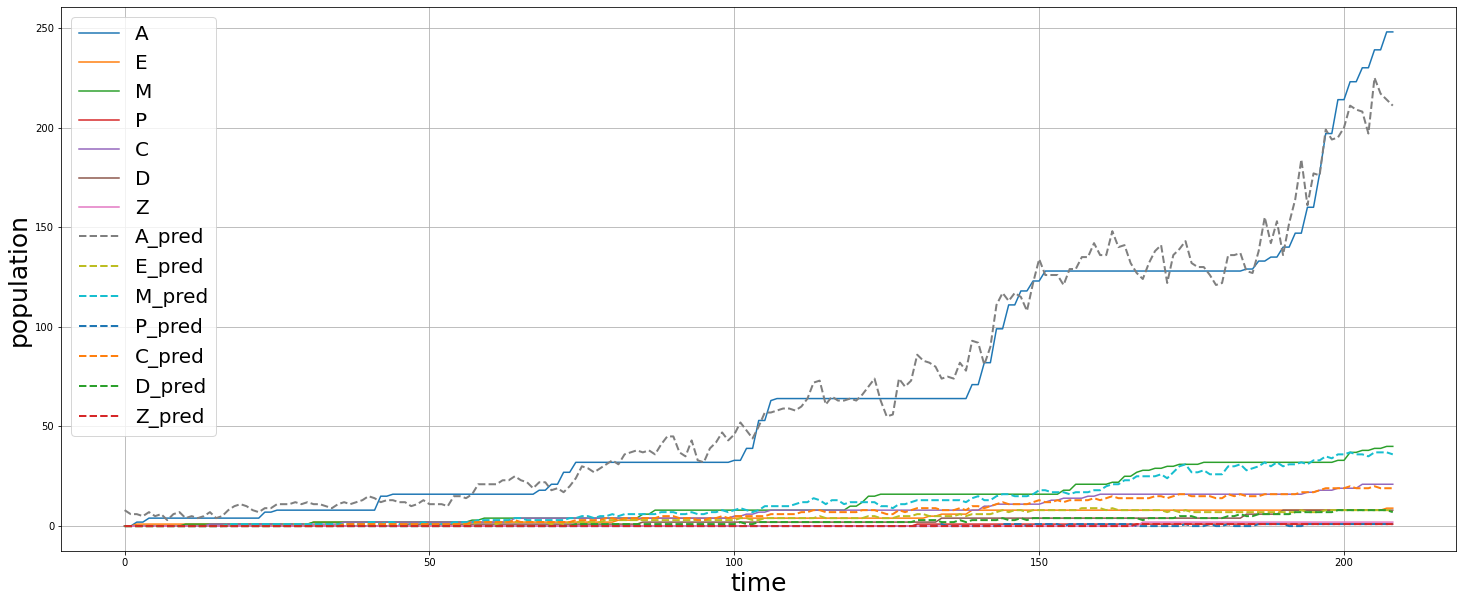

20080731_ceh-32_4_L1


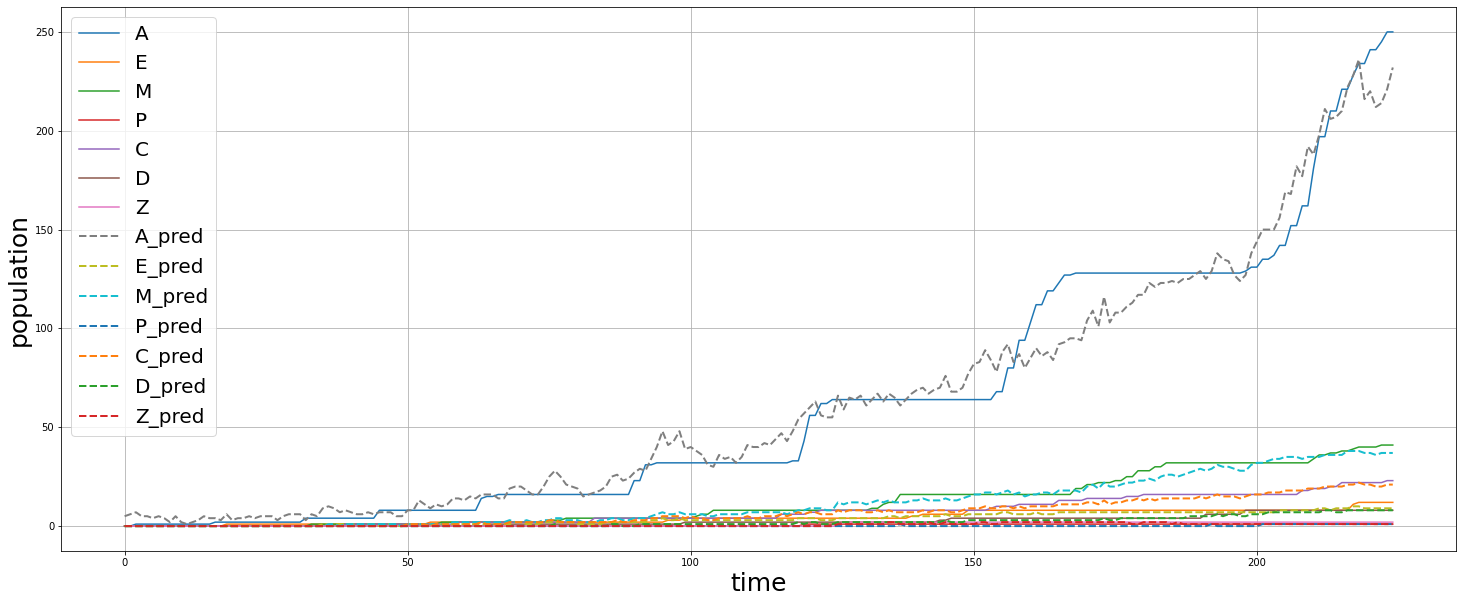

20080731_ceh-32_4_L2


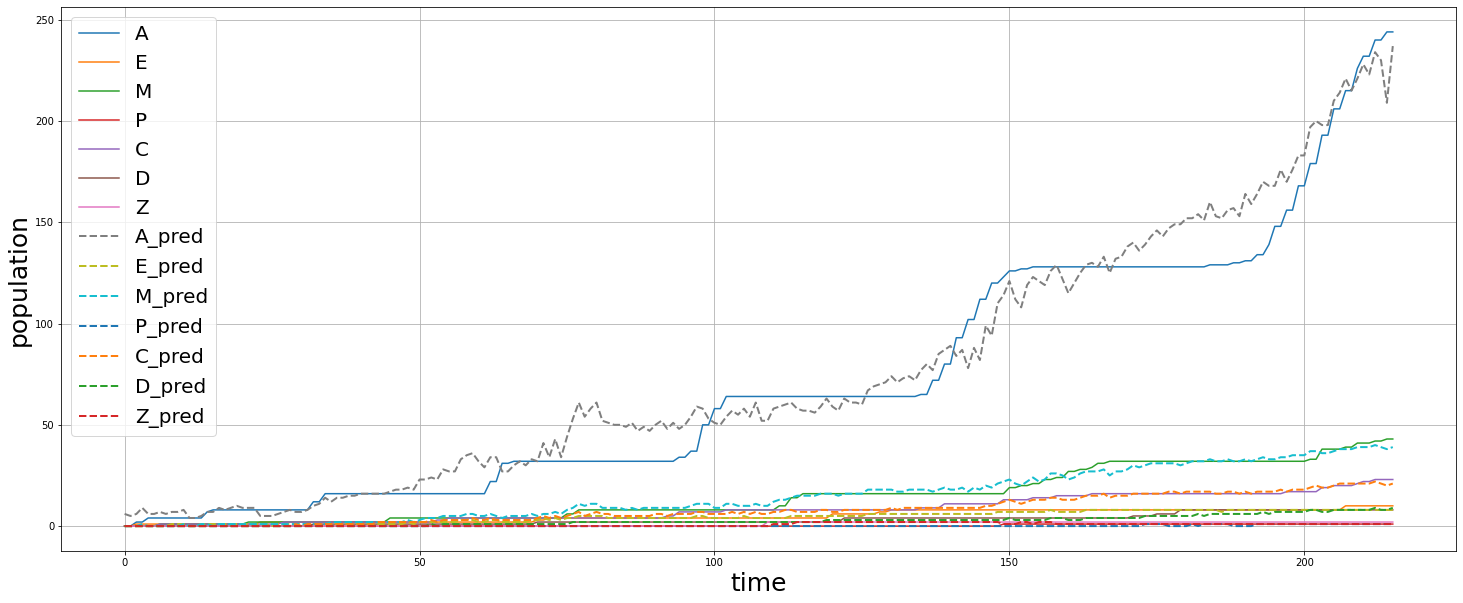

20080808_ceh-41_2_L1


In [126]:
clean_tags = [
             "20080709_ceh-27_1_L1",
              "20080731_ceh-32_4_L1",
              "20080731_ceh-32_4_L2",
              "20080808_ceh-41_2_L1"

              ]
for tag in clean_tags:
    try:
        researcher_vs_model(tag)
        print(tag)
    except:
        pass